# Linear Regression - Real Estate Data Set - Regularization

> Joseph P. Vantassel, Texas Advanced Computing Center - The University of Texas at Austin

In [ ]:
# If you have not done so previously.
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model as lm

## Load Data

In [2]:
# load dataframe
df = pd.read_csv("real_estate.csv")

# convert to numpy
xfeatures = df.iloc[:, 1:-1].to_numpy()
ypredict = df.iloc[:, -1].to_numpy()

# make sure we did the slices correctly
print(f"xfeatures.shape = {xfeatures.shape}")
print(f"ypredict.shape = {ypredict.shape}")

xfeatures.shape = (414, 6)
ypredict.shape = (414,)


## Shuffle and Split

In [3]:
ptrain, pvalid, ptest = 0.7, 0.15, 0.15

# shuffle
rng = np.random.default_rng(1824)
shuffle_idxs = np.arange(len(ypredict))
rng.shuffle(shuffle_idxs)
xfeatures_shuffled = xfeatures[shuffle_idxs]
ypredict_shuffled = ypredict[shuffle_idxs]

# split
start_idx, stop_idx = 0, int(ptrain*len(ypredict))
xfeatures_train, ypredict_train = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_train.shape, ypredict_train.shape)


start_idx, stop_idx = stop_idx, stop_idx+int(pvalid*len(ypredict))
xfeatures_valid, ypredict_valid = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_valid.shape, ypredict_valid.shape)


start_idx, stop_idx = stop_idx, -1
xfeatures_test, ypredict_test = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_test.shape, ypredict_test.shape)


(289, 6) (289,)
(62, 6) (62,)
(62, 6) (62,)


## Normalize

In [4]:
# constant to ensure no divide by zero
eps = 1E-4

def normalize_standardscore(features, means, stds):
    return (features - means)/(stds + eps)
    
def normalize_minmax(features, mins, maxs):
    return (features - mins)/((maxs - mins) + eps)

def normalize_max(features, maxs):
    return features / (maxs + eps)

def rmse(yhat, y):
    return np.sqrt(np.mean(np.power(yhat - y, 2)))

In [6]:
x_train_tmp = xfeatures_train
x_valid_tmp = xfeatures_valid

# add quadratic part (optional: comment out if undesired).
xfeatures_train_quad = []
for start, pfeature in enumerate(x_train_tmp.T):
    for sfeature in x_train_tmp.T[start:]:
        xfeatures_train_quad.append(pfeature * sfeature)
xfeatures_train_quad = np.array(xfeatures_train_quad).T
x_train_tmp = np.hstack((x_train_tmp, xfeatures_train_quad))

xfeatures_valid_quad = []
for start, pfeature in enumerate(xfeatures_valid.T):
    for sfeature in xfeatures_valid.T[start:]:
        xfeatures_valid_quad.append(pfeature * sfeature)
xfeatures_valid_quad = np.array(xfeatures_valid_quad).T
x_valid_tmp = np.hstack((xfeatures_valid, xfeatures_valid_quad))

# normalize
xmean, xstd = np.mean(x_train_tmp, axis=0), np.std(x_train_tmp, axis=0, ddof=1)
x_for_train = normalize_standardscore(x_train_tmp, xmean, xstd)
x_for_valid = normalize_standardscore(x_valid_tmp, xmean, xstd)

y_for_train = ypredict_train
y_for_valid = ypredict_valid

## Train Regularized (or Ridge) Model

This model is different from the purely linear model previously discussed because it includes penalty term for more complex interpreations and should help to reduce the variance in the model we developed previously.

In [7]:
alphas = [0.001, 0.01, 0.1, 0.3, 1, 2, 4, 8, 10]
rmse_train = []
rmse_valid = []
for alpha in alphas:
    rmodel = lm.Ridge(alpha=alpha, fit_intercept=True)
    rmodel_trained = rmodel.fit(x_for_train, y_for_train)
    
    yhat_train = rmodel_trained.predict(x_for_train)
    rmse_train.append(rmse(yhat_train, y_for_train))
    
    yhat_valid = rmodel_trained.predict(x_for_valid)
    rmse_valid.append(rmse(yhat_valid, y_for_valid))

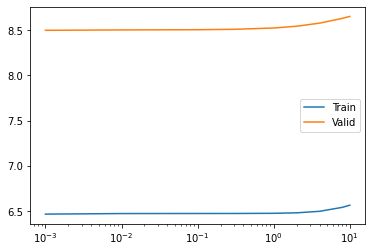

In [8]:
plt.plot(alphas, rmse_train, label="Train")
plt.plot(alphas, rmse_valid, label="Valid")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## Conclusion

If we operate under the assumption we have a high-variance example, these results are somewhat surprising.

I believe what we are seeing is that we do not actually have a high-variance example but rather a high-bias example and that
we were "tricked" ;) by the vertical scale on the learning curve. If we return to the learning curve and plot in on a scale from 0 to 50 we see that the training and validation are actually quite similar to one another. This is inidcating high-bias such that regularization or more training examples will not help to solve the problem. Instead what we need is more real or engineered features in our dataset. For this example it is not possible to gather more features, but we can explore more engineered features. To do this we can either do so manually (through a process called feature engineering) or we can use neural networks to search many linear and non-linear engineered features.